In [131]:
from typing import List, Dict
from tqdm import tqdm

# Analyse sur le hors domaine Priapées

## Objectifs

Évaluer et visualiser les résultats sur la vulgate

## Chargement du corpus GOLD

In [132]:
import lxml.etree as ET

GOLD: List[List[Dict[str, str]]] = [[]]
    
MILESTONES: List[int] = []
    
PRIA_START, PRIA_END = 46, 75
NS = {"t":"http://www.tei-c.org/ns/1.0"}

with open("../../../priapea-lemmat/priapea.xml") as f:
    xml = ET.parse(f)
    for ab_num, ab in enumerate(xml.xpath(
        "//t:ab", 
        namespaces=NS)):
        
        if ab_num < PRIA_START or ab_num > PRIA_END:
            continue
        
        for tok in ab.xpath("./t:w", namespaces=NS):
            token = tok.text
            lemma, pos, msd = (
                tok.attrib["lemma"],
                tok.attrib["pos"], 
                tok.attrib["msd"]
            )
            if pos == "PUNC":
                if token in ".!?":
                    GOLD.append([])
                continue
            GOLD[-1].append({
                "form": token,
                "lemma": lemma,
                "pos": pos,
                "morph": msd
            })
            
        MILESTONES.append(sum(len([x for x in g if not x["form"].startswith("-")]) for g in GOLD if len(g)))
    
GOLD = [g for g in GOLD if len(g)]

In [133]:
#Debug:
print(MILESTONES)
print(len(MILESTONES))

[29, 58, 80, 114, 263, 322, 360, 373, 411, 442, 484, 503, 513, 525, 593, 603, 698, 712, 738, 758, 786, 1028, 1051, 1113, 1125, 1148, 1175, 1187, 1268, 1357]
30


## Reparse morphology for evaluation

In [134]:
TEMP = []
TASKS = "lemma,Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")
for sentence in tqdm(GOLD):
    temp_sentence = []
    for token in sentence:
        new_token = {task: "_" for task in TASKS}
        new_token.update({
            "form": token["form"].lower().replace("v", "u").replace("j", "i"),
            "lemma": token["lemma"].lower(),
            # No POS distinction
            "pos": token["pos"].replace("com", "").replace("pro", "")
        })
        # No disambiguation at the lemmatizer lever
        if new_token["lemma"][-1].isnumeric():
            new_token["lemma"] = new_token["lemma"][:-1]
            
        # Treat morph as separate tasks
        for morph in token["morph"].split("|"):
            task, value = morph.split("=")
            new_token[task] = value
        new_token["Mood_Tense_Voice"] = "|".join([
            new_token.get(task, "_")
            for task in ("Mood", "Tense", "Voice")
        ]).replace("_|_|_", "_")
        
        if new_token["form"].startswith("-"):
            temp_sentence[-1]["form"] += new_token["form"][1:]
            temp_sentence[-1]["lemma"] += "界" + new_token["lemma"]
            continue
        temp_sentence.append(new_token)
        
    TEMP.append(temp_sentence)
GOLD = TEMP

100%|██████████| 78/78 [00:00<00:00, 14961.16it/s]


## Obtention des données (formes uniquement)

In [135]:
TOKENS = [
    [x["form"] for x in sentence]
    for sentence in GOLD
]
nb = 0
for sent in TOKENS:
    print(sent)
    nb += len(sent)
    print(len(sent), nb)

['quicumque', 'uestrum', 'qui', 'uenitis', 'ad', 'cenam', 'libare', 'nullos', 'sustinet', 'mihi', 'uersus', 'illius', 'uxor', 'aut', 'amica', 'riualem', 'lasciuiendo', 'languidum', 'precor', 'reddat', 'et', 'ipse', 'longa', 'nocte', 'dormiat', 'solus', 'libidinosis', 'incitatus', 'erucis']
29 29
['quod', 'partem', 'madidam', 'mei', 'uidetis', 'per', 'quam', 'significor', 'priapus', 'esse', 'non', 'ros', 'est', 'mihi', 'crede', 'nec', 'pruina', 'sed', 'quod', 'sponte', 'sua', 'solet', 'remitti', 'cum', 'mens', 'est', 'pathicae', 'memor', 'puellae']
29 58
['tu', 'quicumque', 'uides', 'circa', 'tectoria', 'nostra', 'non', 'nimium', 'casti', 'carmina', 'plena', 'ioci', 'uersibus', 'obscenis', 'offendi', 'desine', 'non', 'est', 'mentula', 'subducti', 'nostra', 'supercilii']
22 80
['quaedam', 'si', 'placet', 'hoc', 'tibi', 'priape', 'fucosissima', 'me', 'puella', 'ludit', 'et', 'nec', 'dat', 'mihi', 'nec', 'negat', 'daturam', 'causas', 'inuenit', 'usque', 'differendi']
21 101
['quae', 'si', 

## Test

In [136]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 128


OUTPUT = []
MODEL_PATH = "../../../latin-lasla-models/model.tar"

tagger = Tagger(device="cpu", batch_size=100, lower=True, tokenize=False)
tagger.add_model(MODEL_PATH, *TASKS)


for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS], tagger.batch_size)):
    tagged, tasks = tagger.tag(*zip(*chunk))
    OUTPUT.extend([
        [
            (token, dict(zip(tasks, result)))
            for token, result in sentence
        ]
        for sentence in tagged
    ])

2020-06-05 09:37:18,330 : Model ../../../latin-lasla-models/model.tar was serialized with a previous version of `pie`. This might result in issues. Model commit is 050815e, whereas current `pie` commit is 51d48f75.
1it [00:01,  1.85s/it]


## Evaluation

In [137]:
from collections import defaultdict, Counter
RESULTS = []
RAW_SCORES = {
    task: ([], []) # Pred, Truth
    for task in TASKS
}
RAW_SCORES_NOT_EMPTY = {
    task: ([], []) # Pred, Truth
    for task in TASKS
}
ERRORS = {
    task: defaultdict(lambda: defaultdict(Counter))#{truth: {pred: {token: int}} # (token, pred, truth)
    for task in tasks
}
for p_sent, t_sent in zip(OUTPUT, GOLD):
    score_sentence = []
    for (_, p_tags), (t_tags) in zip(p_sent, t_sent):
        token = t_tags["form"]
        p_tags["lemma"] = p_tags["lemma"].lower()
        score_sentence.append((
            p_tags,
            t_tags,
            {task: p_tags[task] == t_tags[task] for task in TASKS}
        ))
        for task in tasks:
            RAW_SCORES[task][0].append(p_tags[task])
            RAW_SCORES[task][1].append(t_tags[task])
            if t_tags[task] != "_":
                RAW_SCORES_NOT_EMPTY[task][0].append(p_tags[task])
                RAW_SCORES_NOT_EMPTY[task][1].append(t_tags[task])
            if t_tags[task] != p_tags[task]:
                ERRORS[task][t_tags[task]][p_tags[task]][token] += 1
    RESULTS.append(score_sentence)

In [138]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

data = [["Task", "Accuracy", "Accuracy on V != _"]]


for task, (pred, truth) in RAW_SCORES.items():
    (pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
    data.append([
        task,
        "{0:.2f}".format(accuracy_score(truth, pred)),
        "{0:.2f}".format(accuracy_score(pred_limited, truth_limited))
    ])
print(tabulate(data))

----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.92      0.92
Deg               0.96      0.91
Numb              0.94      0.94
Person            0.99      0.97
Mood_Tense_Voice  0.96      0.88
Case              0.88      0.81
Gend              0.93      0.82
pos               0.93      0.93
----------------  --------  ------------------


In [139]:
ERRORS["lemma"]

with open("1.4.X-Priapees-Lemma-Confusion.tsv", "w") as f:
    f.write("lemma\tprediction\ttoken\tnumber\n")
    for lemma in ERRORS["lemma"]:
        for pred in ERRORS["lemma"][lemma]:
            for token, count in ERRORS["lemma"][lemma][pred].items():
                f.write(f"{lemma}\t{pred}\t{token}\t{count}\n")

## Visualisation sur le corpus

In [140]:
from math import ceil
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Compute the accuracy on splits
        
SPLITS_TASK = {
    task: []
    for task in RAW_SCORES
}
SPLITS_TASK["size"] = []
DIVIDE_BY = round(sum([len(x) for x in GOLD]) / 20) # 5%

lengths = []
support_done = False
for task, (pred, truth) in RAW_SCORES.items():
    ms_start = 0
    for milestone in MILESTONES:
        SPLITS_TASK[task].append(accuracy_score(truth[ms_start:milestone], pred[ms_start:milestone]))
        length = milestone - ms_start + 1
        if not support_done:
            SPLITS_TASK["size"].append(length)
        ms_start = milestone
    support_done = True
        

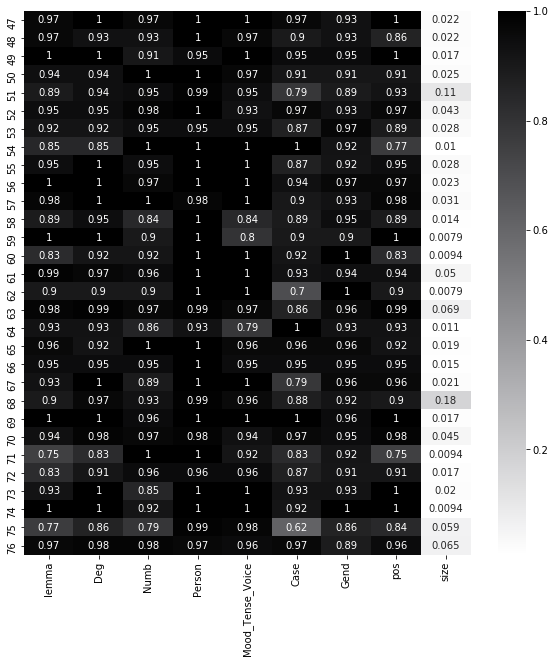

In [141]:
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DF_PRIAPEES = DataFrame(SPLITS_TASK, index=list(range(PRIA_START+1, PRIA_END+2)))
DF_PRIAPEES["size"] = DF_PRIAPEES["size"] / sum(DF_PRIAPEES["size"])

plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(DF_PRIAPEES, annot=True, cmap=cmap)

## Analyse des Priapées en dessous de X %

In [144]:
from IPython.core.display import display, HTML

THRESHOLD = 0.91

TO_CHECK = [
    pria_id - PRIA_START - 1
    for pria_id in (DF_PRIAPEES["lemma"].loc[DF_PRIAPEES["lemma"] < THRESHOLD]).index
]
TO_CHECK_ID = list((DF_PRIAPEES["lemma"].loc[DF_PRIAPEES["lemma"] < THRESHOLD]).index)
    
pred, truth = RAW_SCORES["lemma"]
flatten_tokens = [tok for sent in TOKENS for tok in sent]
ms_start = 0

for pria_id, (ms_start, ms_end) in enumerate(zip([0] + MILESTONES, MILESTONES)):
    #if ms_end is not None:
    #    ms_end += 1
    if pria_id not in TO_CHECK:
        continue
    nice_id = TO_CHECK_ID.pop(0)
    text = []
    nb_tokens = ms_end - ms_start
    size = 1 / nb_tokens
    nb_errors = 0
    for tok, t, p in zip(flatten_tokens[ms_start:ms_end], truth[ms_start:ms_end], pred[ms_start:ms_end]):
        if t == p:
            text.append(tok)
        else:
            text.append(f"<span style='color: red;'>{tok}[<span style='color:green;'>{t}</span>,{p}]</span>")
            nb_errors += 1
            
    text = "<p>"+" ".join(text).replace(" -", "-") + "</p>"
    text = f"""<h2>Priapée {nice_id}</h2>
    <p>
        <small>
        <b>Accuracy:</b> {accuracy_score(truth[ms_start:ms_end], pred[ms_start:ms_end]):.3f} <br />
        <b>Tokens:</b> {ms_end - ms_start}<br />
        <b>Errors: </b> {nb_errors}<br />
        <b>1 error =</b> -{size:.3f} drop in accuracy <br />
        <span style='color:green;'>Ground Truth</span> - <span style='color:red;'>Prediction</span>
        </small>
    </p>
    <p>{text}</p>
    """
    display(HTML(text))
    